# The testing notebook to see if I can try and predict the price of microsoft

Using an lstm and 1 years worth of microsoft data, we'll try and predict what the stock will do

In [31]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [32]:
df = pd.read_csv('data/MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-02,330.299988,333.489990,327.799988,329.489990,326.431274,30766000
1,2021-12-03,331.989990,332.700012,318.029999,323.010010,320.011444,41779300
2,2021-12-06,323.950012,327.450012,319.230011,326.190002,323.161896,30032600
3,2021-12-07,331.640015,335.799988,330.100006,334.920013,331.810883,31021900
4,2021-12-08,335.309998,335.500000,330.799988,334.970001,331.860413,24761000
...,...,...,...,...,...,...,...
247,2022-11-25,247.309998,248.699997,246.729996,247.490005,247.490005,9200800
248,2022-11-28,246.080002,246.649994,240.800003,241.759995,241.759995,24778200
249,2022-11-29,241.399994,242.789993,238.210007,240.330002,240.330002,17956300
250,2022-11-30,240.570007,255.330002,239.860001,255.139999,255.139999,47594200


We just want the closing price for now because we're only using one inputf

In [33]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2021-12-02,329.489990
1,2021-12-03,323.010010
2,2021-12-06,326.190002
3,2021-12-07,334.920013
4,2021-12-08,334.970001
...,...,...
247,2022-11-25,247.490005
248,2022-11-28,241.759995
249,2022-11-29,240.330002
250,2022-11-30,255.139999


A function to convert the strings to datetime objects in the df

In [34]:
def strToDatetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(strToDatetime)
# create the date the index

df.index = df.pop('Date')
df

<ipython-input-34-ec5f268e8453>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(strToDatetime)


,Close
Date,
2021-12-02,329.489990
2021-12-03,323.010010
2021-12-06,326.190002
2021-12-07,334.920013
2021-12-08,334.970001
...,...
2022-11-25,247.490005
2022-11-28,241.759995
2022-11-29,240.330002


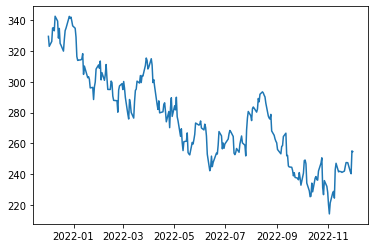

In [35]:
plt.plot(df.index, df['Close'])

Big function to partion the data to get ready for training

In [36]:
def dfToWindowedDf(dataframe, first_date_str, last_date_str, n=3):
    first_date = strToDatetime(first_date_str)
    last_date  = strToDatetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021-03-25'
windowed_df = dfToWindowedDf(df, 
                                '2021-12-07', 
                                '2022-11-30', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-12-07,329.489990,323.010010,326.190002,334.920013
1,2021-12-08,323.010010,326.190002,334.920013,334.970001
2,2021-12-09,326.190002,334.920013,334.970001,333.100006
3,2021-12-10,334.920013,334.970001,333.100006,342.540009
4,2021-12-13,334.970001,333.100006,342.540009,339.399994
...,...,...,...,...,...
243,2022-11-23,241.220001,242.050003,245.029999,247.580002
244,2022-11-25,242.050003,245.029999,247.580002,247.490005
245,2022-11-28,245.029999,247.580002,247.490005,241.759995
246,2022-11-29,247.580002,247.490005,241.759995,240.330002


In [37]:
def windowedDfToDateX_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowedDfToDateX_y(windowed_df)

dates.shape, X.shape, y.shape

((248,), (248, 3, 1), (248,))

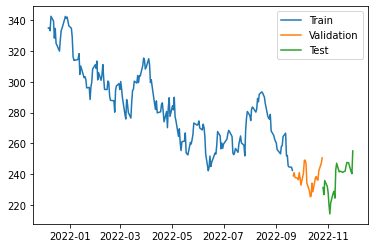

In [38]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 2s 59ms/step - loss: 81973.8672 - mean_absolute_error: 285.2165 - val_loss: 56650.8086 - val_mean_absolute_error: 237.9178
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 81808.0547 - mean_absolute_error: 284.9250 - val_loss: 56526.3398 - val_mean_absolute_error: 237.6561
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 81651.3594 - mean_absolute_error: 284.6492 - val_loss: 56371.1914 - val_mean_absolute_error: 237.3295
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 81434.8438 - mean_absolute_error: 284.2690 - val_loss: 56123.8516 - val_mean_absolute_error: 236.8078
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 81085.9219 - mean_absolute_error: 283.6537 - val_loss: 55782.8945 - val_mean_absolute_error: 236.0869
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 80651.0000 - mean_absolute_error: 282.8879 - val_loss: 55382.38

Epoch 49/100
7/7 [==============================] - 0s 5ms/step - loss: 625.8019 - mean_absolute_error: 20.6879 - val_loss: 2234.2380 - val_mean_absolute_error: 46.7799
Epoch 50/100
7/7 [==============================] - 0s 5ms/step - loss: 625.9142 - mean_absolute_error: 20.7109 - val_loss: 2277.4026 - val_mean_absolute_error: 47.2390
Epoch 51/100
7/7 [==============================] - 0s 5ms/step - loss: 625.8069 - mean_absolute_error: 20.7164 - val_loss: 2279.6470 - val_mean_absolute_error: 47.2628
Epoch 52/100
7/7 [==============================] - 0s 6ms/step - loss: 625.3321 - mean_absolute_error: 20.7214 - val_loss: 2327.3220 - val_mean_absolute_error: 47.7645
Epoch 53/100
7/7 [==============================] - 0s 5ms/step - loss: 626.2812 - mean_absolute_error: 20.7618 - val_loss: 2354.8640 - val_mean_absolute_error: 48.0519
Epoch 54/100
7/7 [==============================] - 0s 5ms/step - loss: 626.6432 - mean_absolute_error: 20.7753 - val_loss: 2357.7900 - val_mean_absolute_e

Epoch 98/100
7/7 [==============================] - 0s 5ms/step - loss: 75.2231 - mean_absolute_error: 6.7398 - val_loss: 120.0371 - val_mean_absolute_error: 9.5754
Epoch 99/100
7/7 [==============================] - 0s 5ms/step - loss: 76.1047 - mean_absolute_error: 6.7577 - val_loss: 201.0759 - val_mean_absolute_error: 13.0795
Epoch 100/100
7/7 [==============================] - 0s 6ms/step - loss: 115.8578 - mean_absolute_error: 8.7176 - val_loss: 235.0432 - val_mean_absolute_error: 14.3288


7/7 [==============================] - 0s 1ms/step


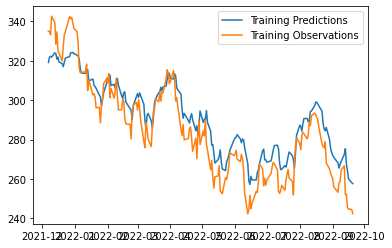

In [40]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 14ms/step


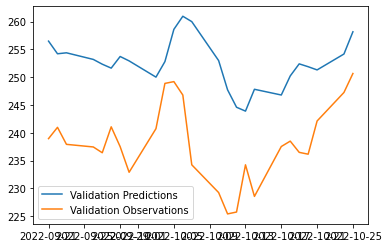

In [41]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 14ms/step


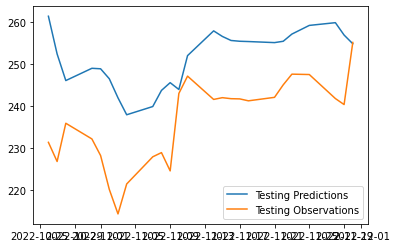

In [42]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

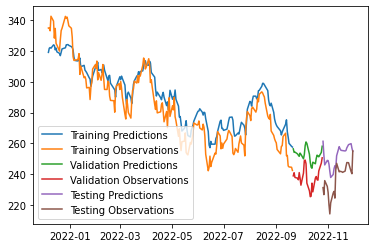

In [43]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [44]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 [==============================] - 0s 14ms/step


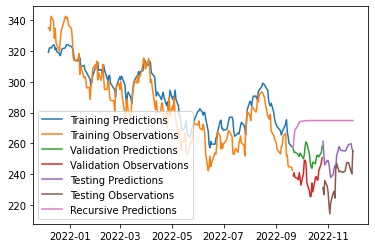

In [45]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])